In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import Generator

batch_size = 256
epochs = 25
generator = Generator().manual_seed(11)

## Dataset

In [2]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('train/')
dataset.class_to_idx

{'baked_potato': 0,
 'baklava': 1,
 'caesar_salad': 2,
 'cheese_sandwich': 3,
 'cheesecake': 4,
 'chicken': 5,
 'chicken_curry': 6,
 'chocolate_cake': 7,
 'donuts': 8,
 'eggs': 9,
 'falafel': 10,
 'fish': 11,
 'french_fries': 12,
 'hamburger': 13,
 'hot_dog': 14,
 'ice_cream': 15,
 'lasagna': 16,
 'omelette': 17,
 'pizza': 18,
 'spaghetti': 19,
 'steak': 20,
 'sushi': 21}

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_size = int(.7 * len(dataset))
val_size = int(.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

trainset, validset, testset = random_split(dataset, [train_size, val_size, test_size], generator)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

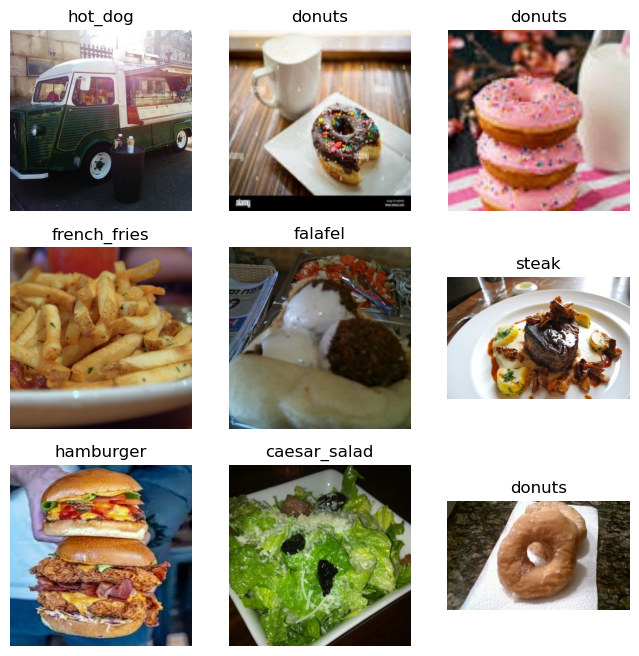

In [4]:
label_to_class = {v:k for k, v in dataset.class_to_idx.items()}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_to_class[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Model

In [5]:
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b3, EfficientNet_B3_Weights

weights = ResNet50_Weights.DEFAULT
# weights = EfficientNet_B3_Weights.DEFAULT
base_model = resnet50(weights=weights)
# base_model = efficientnet_b3(weights=weights)
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
from copy import deepcopy
from torchinfo import summary

model = deepcopy(base_model)
model.fc.out_features = len(label_to_class)
# model.classifier[1].out_features = len(label_to_class)
frozen = [model.conv1, model.bn1, model.layer1, model.layer2, model.layer3]
# frozen = [model.features[:7]]
for layer in frozen:
    for param in layer.parameters():
        param.requires_grad = False
          
summary(model)       

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

# Augmentation

In [7]:
from torchvision.transforms import v2

base_transforms = weights.transforms()

aug_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.RandomAffine(degrees=50, shear=50),
    v2.ToDtype(torch.float32, scale=True),
    base_transforms
])

transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    base_transforms
])

# Train

In [8]:
def train(model, device, criterion, optimizer, scheduler, num_epochs=epochs):
    model.to(device)
    best_val = float('inf')
    best_model = None
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
#         trainloader.dataset.transform = aug_transforms
        for _, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()
        valid_loss = 0.0
        model.eval()
#         validloader.dataset.transform = transforms
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
        if best_val > valid_loss:
            best_val = valid_loss
            best_model = deepcopy(model)
        print(f'[{epoch + 1}] train loss: {train_loss/len(trainloader):.3f} validation loss: {valid_loss/len(validloader):.3f}')
    return best_model

In [9]:
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import CrossEntropyLoss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

dataset.transform = aug_transforms

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=5)


model = train(model, device, criterion, optimizer, scheduler)

cuda:0
[1] train loss: 1.692 validation loss: 1.057
[2] train loss: 0.856 validation loss: 0.923
[3] train loss: 0.726 validation loss: 0.836
[4] train loss: 0.667 validation loss: 0.774
[5] train loss: 0.614 validation loss: 0.752
[6] train loss: 0.532 validation loss: 0.669
[7] train loss: 0.488 validation loss: 0.673
[8] train loss: 0.478 validation loss: 0.657
[9] train loss: 0.451 validation loss: 0.668
[10] train loss: 0.438 validation loss: 0.616
[11] train loss: 0.433 validation loss: 0.639
[12] train loss: 0.428 validation loss: 0.625
[13] train loss: 0.438 validation loss: 0.642
[14] train loss: 0.428 validation loss: 0.600
[15] train loss: 0.421 validation loss: 0.619
[16] train loss: 0.425 validation loss: 0.615
[17] train loss: 0.419 validation loss: 0.654
[18] train loss: 0.425 validation loss: 0.641
[19] train loss: 0.430 validation loss: 0.619
[20] train loss: 0.413 validation loss: 0.651
[21] train loss: 0.433 validation loss: 0.624
[22] train loss: 0.417 validation lo

# Test

In [10]:
dataset.transform = transforms

incorrects = []
preds = []
gt = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        idxs_mask = (predicted != labels).view(-1)
        incorrects.append(images[idxs_mask].cpu())
        preds += [predicted[idxs_mask].cpu()]
        gt += [labels[idxs_mask].cpu()]

incorrects = torch.cat(incorrects)
preds = torch.cat(preds)
gt = torch.cat(gt)

print(f'Accuracy on the {len(testset)} test images: {100 * (1 - len(incorrects) / len(testset)):.3f} %')

Accuracy on the 3614 test images: 89.236 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


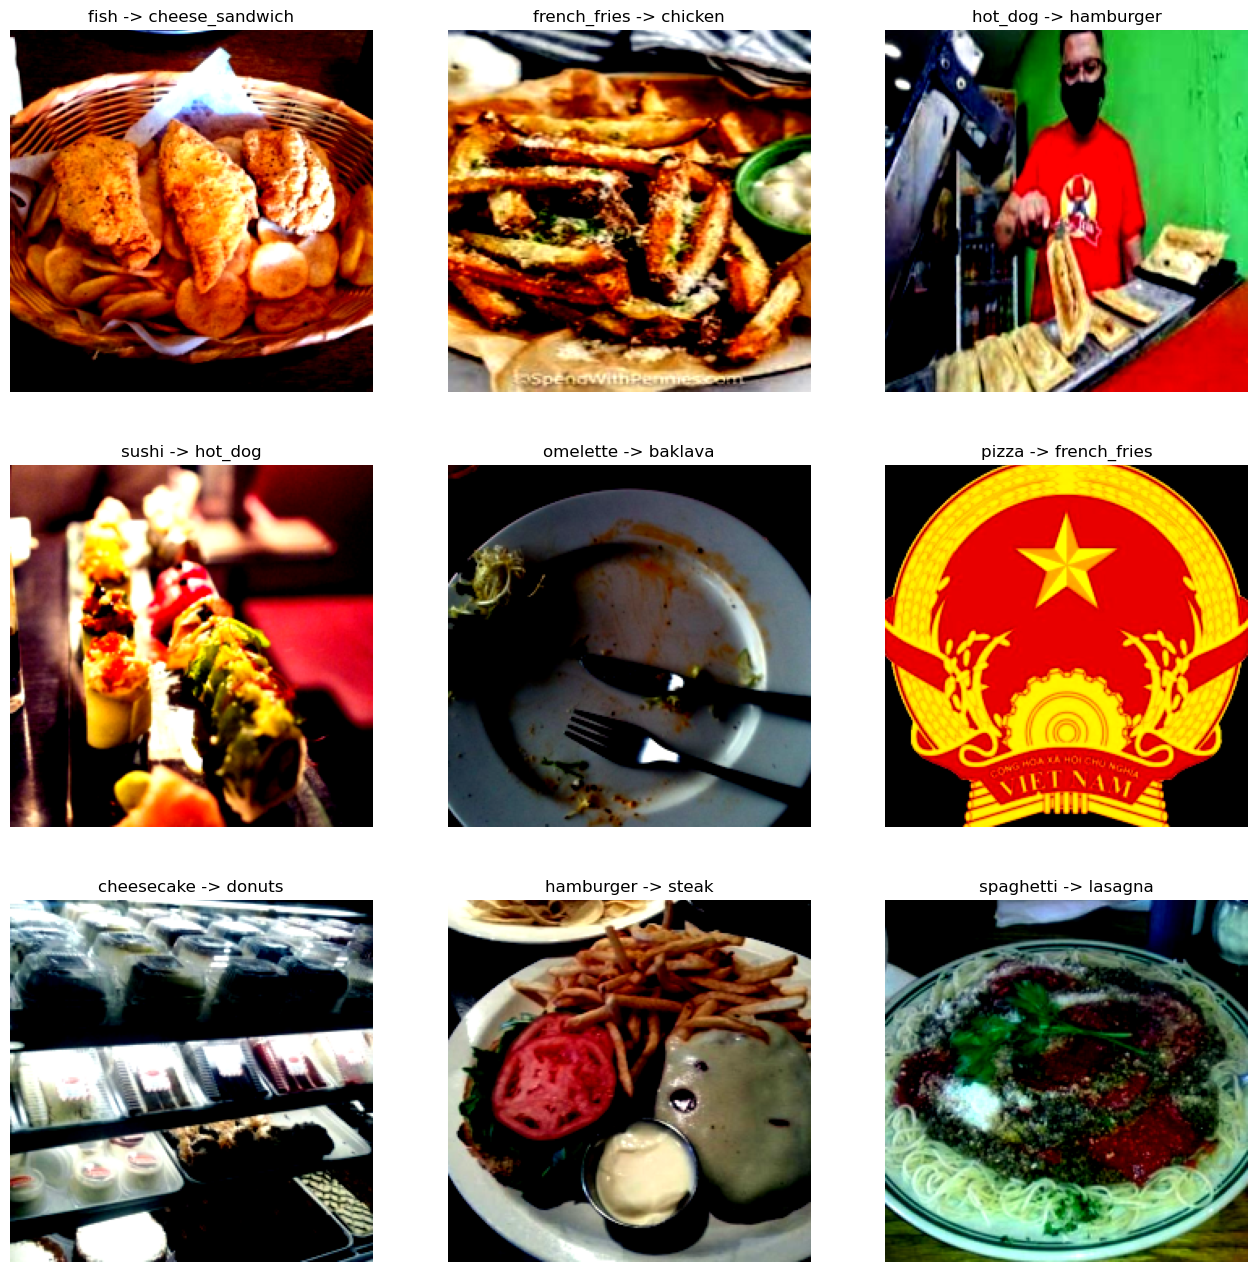

In [11]:
from torchvision.utils import make_grid


mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
cols, rows = 3, 3
n = rows * cols
figure = plt.figure(figsize=(16, 16))
for i in range(n):
    idx = torch.randint(len(incorrects), size=(1,)).item()
    img = incorrects[idx]
    img = img * mean + std     # unnormalize
    npimg = img.numpy()
    figure.add_subplot(rows, cols, i+1)
    plt.title(f'{label_to_class[gt[idx].item()]} -> {label_to_class[preds[idx].item()]}')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")   
plt.show()

In [12]:
from torch import save

model.transforms = transforms
save(model, 'resnet.pt')